# First Step in BNN-ABC-SS

The objective is to train a BBN using ABC-SS on some curved data

We are going to pick the sin because that is hard enough one but still manageable

In [1]:
# All the anoying imports
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

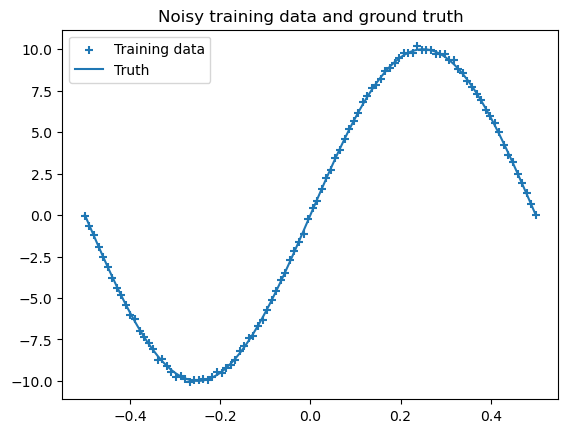

In [3]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10*np.sin(2*np.pi*x) + epsilon

# def f(x, sigma):
#     epsilon = np.random.randn(*x.shape) * sigma
#     return np.cos(x) + epsilon

train_size = 100
noise = 0.1

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
# X = np.linspace(-np.pi, np.pi, train_size).reshape(-1, 1)

y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend()


+ `X` here is a (100,1) array
+ `y` is the noised sin, same shape as before
+ `y_true` is the true value of y, 
same shape as before

NetWork architecture :

+ Input dimension : 1
+ Layer1 : 20
+ layer2 : 20
+ Output : 1

In [4]:
# Hyperparameters
# n0 = 1
# n1 = 20
# n2 = 20
# n3 = 1

In [5]:
def segment(theta, ns):

    total_len = np.sum([(ns[i]+1)*ns[i+1] for i in range(len(ns)-1)])
    if (total_len != len(theta)):
        print("Error : Wrong dimensions\n")
        return

    param_list = []
    index = 0
    for i in range(len(ns)-1):

        W = torch.Tensor(
            theta[index: (index + ns[i]*ns[i + 1])]).reshape(ns[i+1], ns[i])
        index += ns[i]*ns[i + 1]

        b = torch.Tensor(theta[index: (index + ns[i+1])]).reshape(ns[i+1])
        index += ns[i + 1]

        param_list.append(W)
        param_list.append(b)

    return param_list


In [6]:
def wrap(param_list):
    listLen = len(param_list)

    theta = param_list[0].reshape(np.prod(param_list[0].size()), 1)

    for i in range(1, listLen):
        theta = torch.concat(
            (theta, param_list[i].reshape(np.prod(param_list[i].size()), 1)))

    return theta


In [7]:
class FNN(nn.Module):
    def __init__(self, ns, theta=None):
        super(FNN, self).__init__()
        self.funclist = []
        self.nbLayers = len(ns)
        self.ns = ns
        for i in range(self.nbLayers-1):
            self.funclist.append(nn.Linear(ns[i], ns[i+1]))
        if (theta != None):
            self.update_weights(theta)

    def forward(self, x):
        for i in range(self.nbLayers - 2):
            x = self.funclist[i](x)
            x = torch.tanh(x)
        x = self.funclist[self.nbLayers - 2](x)
        return x

    def update_weights(self, thetas):
        param_list = segment(thetas, self.ns)
        nbparam = len(param_list)
        with torch.no_grad():
            for i in range(self.nbLayers - 1):
                self.funclist[i].weight = nn.Parameter(param_list[i*2])
                self.funclist[i].bias = nn.Parameter(param_list[i*2 + 1])

    def getTheta(self):
        param_list = []
        for i in range(self.nbLayers - 1):
            param_list.append(self.funclist[i].weight)
            param_list.append(self.funclist[i].bias)

        return wrap(param_list)


In [10]:
def modelSize(ns) :
    return np.sum([(ns[i]+1)*ns[i+1] for i in range(len(ns)-1)])

+ `X` here is a (100,1) tensor
+ `y` is the noised sin, same shape as before
+ `y_true` is the true value of y, 
same shape as before

In [9]:
XT = torch.Tensor(X).reshape(X.shape)
y = torch.Tensor(y).reshape(y.shape)
y_true = torch.Tensor(y_true).reshape(y_true.shape)


In [10]:
def plotTubeMean(XT, y, thetas, ns):
    
    N = thetas.shape[1]
    y_hats = torch.concat(
        tuple([FNN(ns, thetas[:, i]).forward(XT) for i in range(0, N)]), 1)

    std = torch.sqrt(y_hats.var(1))
    mean = y_hats.mean(1)

    binf = (mean - 3*std).reshape(y.shape).detach().numpy()
    bsup = (mean + 3*std).reshape(y.shape).detach().numpy()

    plt.fill_between(XT.ravel(), binf[:, 0],
                     bsup[:, 0], color='gray', label="[]")
    plt.plot(XT, (mean).reshape(y.shape).detach().numpy(),
             label="Mean", color="r")
    plt.scatter(XT, y, marker='+', color='k')
    plt.legend()


In [11]:
def plotTubeMedian(XT, y, thetas, ns):

    N = thetas.shape[1]
    y_hats = torch.concat(
        tuple([FNN(ns, thetas[:, i]).forward(XT) for i in range(0, N)]), 1)

    q2_5 = y_hats.quantile(0.025, 1).reshape(y.shape).detach().numpy()
    q97_5 = y_hats.quantile(0.975, 1).reshape(y.shape).detach().numpy()
    q25 = y_hats.quantile(0.25, 1).reshape(y.shape).detach().numpy()
    q75 = y_hats.quantile(0.75, 1).reshape(y.shape).detach().numpy()

    plt.fill_between(XT.ravel(), q2_5[:, 0],
                     q97_5[:, 0], alpha=0.5, color='gray')
    plt.fill_between(XT.ravel(), q25[:, 0], q75[:, 0],
                     alpha=0.5, color='k', label='IQR')
    plt.plot(XT, y_hats.quantile(0.5, 1).reshape(
        y.shape).detach().numpy(), label="Median", color='r')

    plt.scatter(XT, y, marker='+', color='k', label='Training data')
    plt.legend()


In [12]:
def BnnAbcSs(N, l, P0, epsilon, sigma_0, fact, ns, XT, y):
    NP0 = int(N*P0)
    invP0 = int(1/P0)
    lll = modelSize(ns)

    thetas = torch.randn(lll, N)

    y_hats = torch.concat(
        tuple([FNN(ns, thetas[:, i]).forward(XT) for i in range(0, N)]), 1)

    rho_n = torch.cdist(y_hats.t(), y.t())

    sigma_j = sigma_0

    l_eps = []
    for j in range(0, l):
        rho_n, indices = torch.sort(rho_n, 0)
        thetas = thetas[:, indices.t()[0]]

        epsilon_j = rho_n[int(N*P0)]

        # for debugging purposes
        l_eps.append(epsilon_j)

        thetasSeeds = (thetas[:, :NP0].t()).repeat(invP0, 1).t()
        rho_nSeeds = (rho_n[:NP0, 0].reshape(NP0, 1)).repeat(invP0, 1)

        # Resampling using seeds
        thetasResamples = torch.normal(thetasSeeds, sigma_j)
        # Evaluating performaces
        y_hatsResamples = torch.concat(
            tuple([FNN(ns, thetasResamples[:, i]).forward(XT) for i in range(0, N)]), 1)
        rho_nResamples = torch.cdist(y_hatsResamples.t(), y.t())

        # Mask creation
        mask = torch.diag((rho_nResamples <= rho_nSeeds)[:, 0].float())

        thetas = torch.matmul(thetasResamples, mask) + \
            torch.matmul(thetasSeeds, torch.eye(N) - mask)
        rho_n = torch.matmul(mask, rho_nResamples) + \
            torch.matmul(torch.eye(N) - mask, rho_nSeeds)


        sigma_j = sigma_j - 0.1

    return thetas, rho_n

In [15]:
# Hypperparameters
N = 2000
l = 100
P0 = 0.1
epsilon = 0.1 
sigma_0 = 0.1*(l + 1)
fact = 0.1
ns = [1,2,1]
tol = 1e-3

#Code begins here
NP0 = int(N*P0)
invP0 = int(1/P0)
lll = modelSize(ns)

#Initial Guess
thetas = torch.randn(lll, N)

y_hats = torch.concat(
    tuple([FNN(ns, thetas[:, i]).forward(XT) for i in range(0, N)]), 1)

rho_n = torch.cdist(y_hats.t(), y.t())

sigma_j = sigma_0
# Relative learning rate
lr = []
stop = []

# Iteration
l_eps = []
for j in range(0, l):
    rho_n, indices = torch.sort(rho_n, 0)
    thetas = thetas[:, indices.t()[0]]

    epsilon_j = rho_n[int(N*P0)]

    # Lr
    rho_nOld = rho_n

    # for debugging purposes
    l_eps.append(epsilon_j)

    thetasSeeds = (thetas[:, :NP0].t()).repeat(invP0, 1).t()
    rho_nSeeds = (rho_n[:NP0, 0].reshape(NP0, 1)).repeat(invP0, 1)

    # Resampling using seeds
    thetasResamples = torch.normal(thetasSeeds, sigma_j)
    # Evaluating performaces
    y_hatsResamples = torch.concat(
        tuple([FNN(ns, thetasResamples[:, i]).forward(XT) for i in range(0, N)]), 1)
    rho_nResamples = torch.cdist(y_hatsResamples.t(), y.t())

    # Mask creation
    mask = torch.diag((torch.bernoulli(torch.sigmoid(rho_nResamples - rho_n)))[:, 0].float())

    thetas = torch.matmul(thetasResamples, mask) + \
        torch.matmul(thetasSeeds, torch.eye(N) - mask)
    rho_n = torch.matmul(mask, rho_nResamples) + \
        torch.matmul(torch.eye(N) - mask, rho_nSeeds)

    sigma_j = sigma_j - 0.1

    #Updating relative rate
    lr.append(torch.cdist(rho_n.t(), rho_nOld.t()) / torch.norm(rho_n))

    if(l > 2) :
        valStop = (lr[j] < tol) and (lr[j-1] < tol) and (lr[j-2] < tol)
        stop.append(valStop)
        if valStop :
            break


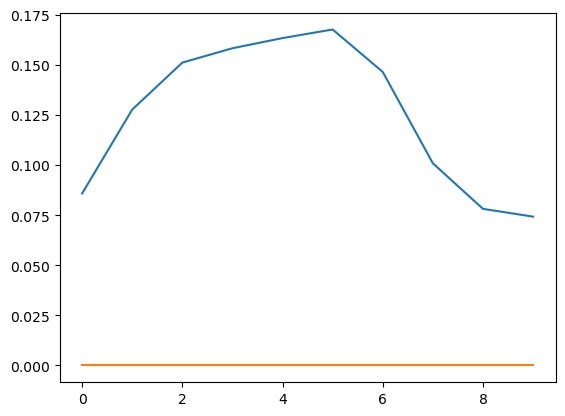

In [16]:
ms = torch.concat(tuple(lr))
plt.plot(ms.detach().numpy())
mk = torch.concat(tuple(stop)).float()
plt.plot(mk.detach().numpy()* 0.1)

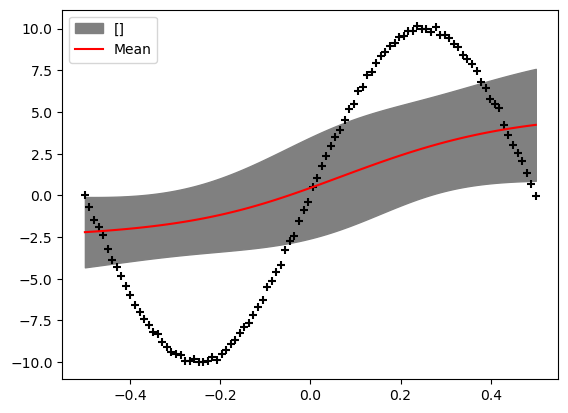

In [17]:
plotTubeMean(XT, y, thetas, ns)

In [18]:
# Hypperparameters
N = 100
l = 5
P0 = 0.1
epsilon = 0.1 
sigma_0 = 0.1*(l + 1)
fact = 0.1
ns = [1,2,1]
tol = 1e-3

#Code begins here
NP0 = int(N*P0)
invP0 = int(1/P0)
lll = modelSize(ns)

#Initial Guess
thetas = torch.randn(lll, N)

y_hats = torch.concat(
    tuple([FNN(ns, thetas[:, i]).forward(XT) for i in range(0, N)]), 1)

rho_n = torch.cdist(y_hats.t(), y.t())

sigma_j = sigma_0
# Relative learning rate
lr = []
stop = []

# Iterationsigma_j = sigma_0
# Relative learning rate
lr = []
stop = []
l_eps = []

In [44]:
## Hercomes the sun

rho_n, indices = torch.sort(rho_n, 0)
thetas = thetas[:, indices.t()[0]]

epsilon_j = rho_n[int(N*P0)]

# Lr
rho_nOld = rho_n

# for debugging purposes
l_eps.append(epsilon_j)

thetasSeeds = (thetas[:, :NP0].t()).repeat(invP0, 1).t()
rho_nSeeds = (rho_n[:NP0, 0].reshape(NP0, 1)).repeat(invP0, 1)

# Resampling using seeds
thetasResamples = torch.normal(thetasSeeds, sigma_j)
# Evaluating performaces
y_hatsResamples = torch.concat(
    tuple([FNN(ns, thetasResamples[:, i]).forward(XT) for i in range(0, N)]), 1)
rho_nResamples = torch.cdist(y_hatsResamples.t(), y.t())

# Mask creation
mask = torch.diag((torch.bernoulli(torch.sigmoid(rho_nResamples - rho_n)))[:, 0].float())

thetas = torch.matmul(thetasResamples, mask) + \
    torch.matmul(thetasSeeds, torch.eye(N) - mask)
rho_n = torch.matmul(mask, rho_nResamples) + \
    torch.matmul(torch.eye(N) - mask, rho_nSeeds)

sigma_j = sigma_j - 0.1

In [8]:
ys = torch.Tensor([[1,0],[0,1],[1,1]])
y = torch.Tensor([[1],[0]])


In [9]:
torch.cdist(ys, y.t())

tensor([[0.0000],
        [1.4142],
        [1.0000]])

In [13]:
modelSize([1,2,1])

7

In [15]:
torch.relu(ys)

tensor([[1., 0.],
        [0., 1.],
        [1., 1.]])